In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import zipline
from zipline.api import (
    future_symbol,
    set_commission,
    set_slippage,
    schedule_function,
    date_rules,
    time_rules,
    continuous_future,
    order_target,
)

from datetime import datetime
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np

from zipline.finance.commission import PerTrade, PerContract
from zipline.finance.slippage import FixedSlippage, VolatilityVolumeShare

# We'll use this to find a future date, X months out.
from dateutil.relativedelta import relativedelta

<IPython.core.display.Javascript object>

In [3]:
# settings
spread_months = 12
pos_per_side = 5
target_exposure_per_side = 1.5
initial_portfolio_millions = 1
volume_order_cap = 0.25

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Drawdown')

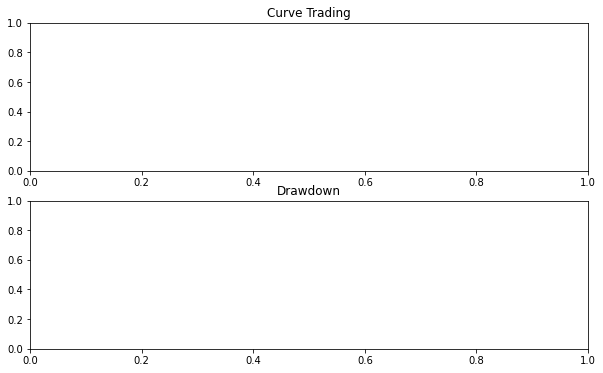

<IPython.core.display.Javascript object>

In [4]:
# DataFame for storing and updating the data that we want to graph
dynamic_results = pd.DataFrame()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(211)
ax.set_title('Curve Trading')
ax2 = fig.add_subplot(212)
ax2.set_title('Drawdown')


In [5]:
def initialize(context):
    """
    Friction Settings
    """
    context.enable_commission = True
    context.enable_slippage = True

    if context.enable_commission:
        comm_model = PerContract(cost=0.85, exchange_fee=1.5)
    else:
        comm_model = PerTrade(cost=0.0)
    set_commission(us_futures=comm_model)

    if context.enable_slippage:
        slippage_model = VolatilityVolumeShare(volume_limit=0.3)
    else:
        slippage_model = FixedSlippage(spread=0.0)
    set_slippage(us_futures=slippage_model)

    """
    Markets to trade
    """
    most_liquid_commods = [
        "CL",
        "HO",
        "RB",
        "NG",
        "GC",
        "LC",
        "_C",
        "_S",
        "_W",
        "SB",
        "HG",
        "CT",
        "KC",
    ]

    context.universe = [
        continuous_future(market, offset=0, roll="volume", adjustment="mul")
        for market in most_liquid_commods
    ]

    schedule_function(weekly_trade, date_rules.week_start(), time_rules.market_close())

    schedule_function(update_chart, date_rules.month_start(), time_rules.market_close())

<IPython.core.display.Javascript object>

In [6]:
def update_chart(context, data):
    # This function continuously update the graph during the backtest
    today = data.current_session.date()
    pv = context.portfolio.portfolio_value
    exp = context.portfolio.positions_exposure
    dynamic_results.loc[today, "PortfolioValue"] = pv

    drawdown = (pv / dynamic_results["PortfolioValue"].max()) - 1
    exposure = exp / pv
    dynamic_results.loc[today, "Drawdown"] = drawdown

    if ax.lines:
        ax.lines[0].set_xdata(dynamic_results.index)
        ax.lines[0].set_ydata(dynamic_results.PortfolioValue)
        ax2.lines[0].set_xdata(dynamic_results.index)
        ax2.lines[0].set_ydata(dynamic_results.Drawdown)
    else:
        ax.plot(dynamic_results.PortfolioValue)
        ax2.plot(dynamic_results.Drawdown)

    ax.set_ylim(
        dynamic_results.PortfolioValue.min(), dynamic_results.PortfolioValue.max()
    )
    ax.set_xlim(dynamic_results.index.min(), dynamic_results.index.max())
    ax2.set_ylim(dynamic_results.Drawdown.min(), dynamic_results.Drawdown.max())
    ax2.set_xlim(dynamic_results.index.min(), dynamic_results.index.max())

    fig.canvas.draw()

<IPython.core.display.Javascript object>

In [7]:
def weekly_trade(context, data):
    # Empty DataFrame to be filled in later.
    carry_df = pd.DataFrame(index=context.universe)

    for continuation in context.universe:
        # Get the chain
        chain = data.current_chain(continuation)

        # Transform the chain into dataframe
        df = pd.DataFrame(index=chain)
        for contract in chain:
            df.loc[contract, "future"] = contract
            df.loc[contract, "expiration_date"] = contract.expiration_date

        # Locate the contract closest to the target date.
        # X months out from the front contract.
        closest_expiration_date = df.iloc[0].expiration_date
        target_expiration_date = closest_expiration_date + relativedelta(
            months=+spread_months
        )
        df["days_to_target"] = abs(df.expiration_date - target_expiration_date)
        target_contract = df.loc[df.days_to_target == df.days_to_target.min()]

        # Get prices for front contract and target contract
        prices = data.current([df.index[0], target_contract.index[0]], "close")

        # Check the exact day difference between the contracts
        days_to_front = int(
            (target_contract.expiration_date - closest_expiration_date)[0].days
        )

        # Calculate the annualized carry
        annualized_carry = (
            np.power((prices[0] / prices[1]), (365 / days_to_front))
        ) - 1

        carry_df.loc[continuation, "front"] = df.iloc[0].future
        carry_df.loc[continuation, "next"] = target_contract.index[0]
        carry_df.loc[continuation, "carry"] = annualized_carry

    # Sort on carry
    carry_df.sort_values("carry", inplace=True, ascending=False)
    carry_df.dropna(inplace=True)

    new_portfolio = []
    new_longs = []
    new_shorts = []

    # Contract Selection
    for i in np.arange(0, pos_per_side):
        j = -(i + 1)

        # Buy top, short bottom
        long_contract = carry_df.iloc[i].next
        short_contract = carry_df.iloc[j].next

        new_longs.append(long_contract)
        new_shorts.append(short_contract)

    # Get data for the new portfolio
    new_portfolio = new_longs + new_shorts
    hist = data.history(
        new_portfolio,
        fields=["close", "volume"],
        frequency="1d",
        bar_count=10,
    )

    # Simple Equal Weighted
    target_weight = (
        target_exposure_per_side * context.portfolio.portfolio_value
    ) / pos_per_side

    # Trading
    for contract in new_portfolio:
        # Slice history for contract
        h = hist.xs(contract, 2)

        # Equal weighted, with volume based cap.
        contracts_to_trade = target_weight / contract.price_multiplier / h.close[-1]

        # Position size cap
        contracts_cap = int(h["volume"].mean() * volume_order_cap)

        # Limit trade size to position size cap.
        contracts_to_trade = min(contracts_to_trade, contracts_cap)

        # Negative position for shorts
        if contract in new_shorts:
            contracts_to_trade *= -1

        # Execute
        order_target(contract, contracts_to_trade)

    # Close any other open position
    for pos in context.portfolio.positions:
        if pos not in new_portfolio:
            order_target(pos, 0.0)

<IPython.core.display.Javascript object>

In [8]:
start = pd.Timestamp("2001-01-01 08:15:21", tz="utc")
end = pd.Timestamp("2018-12-30 08:15:12", tz="utc")

<IPython.core.display.Javascript object>

In [9]:
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    capital_base=initial_portfolio_millions * 1000000,  
    data_frequency = 'daily', 
    bundle='random_futures' )

<string>:13: UserWarning: Overwriting bundle with name 'random_futures'


UnknownBundle: No bundle registered with the name 'futures'

<IPython.core.display.Javascript object>

In [10]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

NameError: name 'perf' is not defined

<IPython.core.display.Javascript object>